In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os, random

# Display training sample from file chosen randomly

In [2]:
def get_sample(filename):
    # read file to np array
    sample = np.fromfile(filename, count=-1, dtype=np.single)
    # pad zeros to make a constant length of 251
    padding = int((251 - len(sample))/2)
    sample = np.pad(sample,padding)
    return sample

In [3]:
def get_random_file(dir):
    filename = str(dir) + "/" + random.choice(os.listdir(dir)) 
    return filename

In [4]:
def display_random_sample(dataset):
    # get random file
    filename = get_random_file(dataset) 
    sample = get_sample(filename)
    # plot random file
    plt.title(filename)
    plt.plot(sample) 
    plt.show()

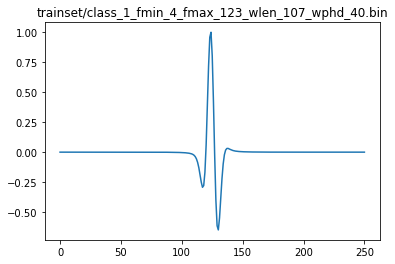

In [40]:
display_random_sample("trainset")

# Create Convolultion Nueral Network Model

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
import re

In [43]:
# Define the network
def create_network():
    net = tf.keras.models.Sequential()
    input_shape = [251,1]
    net.add(Conv1D(3, 3, activation='relu', input_shape=input_shape))
    net.add(MaxPooling1D(pool_size=2, strides=2))
    net.add(Conv1D(3, 3, activation='relu'))
    net.add(MaxPooling1D(pool_size=2, strides=2))
    net.add(Flatten())
    net.add(Dense(9, activation='relu'))
    net.add(Dense(5, activation='relu'))
    net.add(Dense(2))
    return net


In [44]:
# create network
model = create_network()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 249, 3)            12        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 3)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 3)            30        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 61, 3)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 183)               0         
                                                                 
 dense (Dense)               (None, 9)                 1

# Setting up the Training Dataset

In [45]:
# Augment the training set with by simulating noise
def awgn(s,SNRdB):
    # db to linear scale
    snr = 10**(SNRdB/10)
    
    # power
    P = sum(abs(s)**2)/len(s)

    # noise spectral density
    N0=P/snr 
    
    # noise
    n = np.sqrt(N0/2)*(np.random.standard_normal(s.shape))
    
    r = s + n 
    
    return r

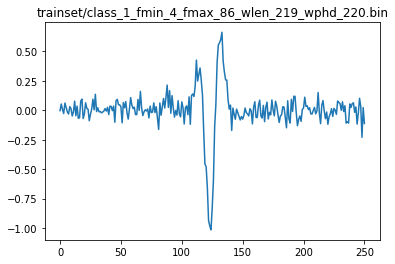

In [78]:
# display augmented sample
def display_random_augmented_sample(dataset):
    # get random file
    filename = get_random_file(dataset) 
    sample = get_sample(filename)
    snrdb = np.random.randint(2,20)
    sample = awgn(sample, snrdb)
    # plot random file
    plt.title(filename)
    plt.plot(sample)
    plt.show()
display_random_augmented_sample("trainset")

In [82]:
# Get dataset and labels
# you can multiply the samples 100X when doing augmentation
train_dataset_size = 150*100
traindir = "trainset"

# initialize the dataset and labels
train_dataset = np.zeros((train_dataset_size, 251))
train_labels = np.zeros(train_dataset_size)

for i in range(train_dataset_size):
    # get file data
    filename = get_random_file(traindir)
    sample = get_sample(filename)
    snrdb = np.random.randint(2,20)
    sample = awgn(sample, snrdb)
    train_dataset[i,:] = sample
    
    # get first number from filenmae, this is the class id
    classid = int(re.search('[0-9]+', filename).group()) - 1
    train_labels[i] = classid
    

# Training the Model

In [83]:
# train the model
epochs = 15
print("Training for " + str(epochs) + " epochs using " + str(traindir) + " data")
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x=train_dataset, y=train_labels, epochs=epochs)
#display_metrics(history)


Training for 15 epochs using trainset data
Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0041 - accuracy: 0.9990
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0030 - accuracy: 0.9990
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 5.9571e-04 - accuracy: 0.9999
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 1.3507e-04 - accuracy: 1.0000
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 7.0832e-05 - accuracy: 1.0000
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 1.0630e-04 - accuracy: 1.0000
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 5.9645e-05 - accuracy: 1.0000
Epoch 8/15
469/469 [==============================] - 2s 4ms/step - loss: 1.9093e-05 - accuracy: 1.0000
Epoch 9/15
469/469 [==============================] - 2s 4ms/step - loss: 1.7801e-05 - accuracy: 1.0000
Epoch 10/15
469/469 [========

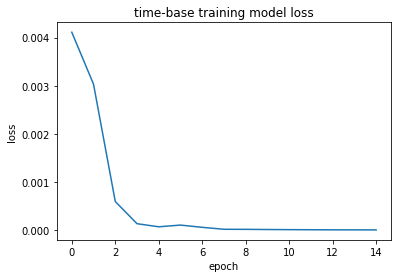

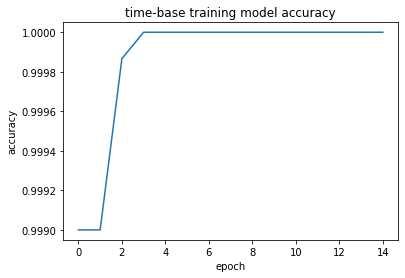

In [84]:
# Visualize learning progress 
plt.plot(history.history['loss'])
plt.title('time-base training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('time-base training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


# Testing the Model

In [86]:
# Get dataset and labels
test_dataset_size = 20
testdir = "testset"

# initialize the dataset and labels
test_dataset = np.zeros((test_dataset_size, 251))
test_labels = np.zeros(test_dataset_size)

for i in range(test_dataset_size):
    # get file data
    filename = get_random_file(testdir)
    sample = get_sample(filename)
    test_dataset[i,:] = sample
    
    # get first number from filenmae, this is the class id
    classid = int(re.search('[0-9]+', filename).group()) - 1
    test_labels[i] = classid


In [110]:
filename = get_random_file("testset")
print(filename)
test_loss, test_acc = model.evaluate(test_dataset, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

testset/class_2_noise_per_8_fmin_13_fmax_114_wlen_227_wphd_270.bin
1/1 [==============================] - 0s 22ms/step - loss: 3.4326e-05 - accuracy: 1.0000

Test accuracy: 1.0


# Frequency and Time Domain Comparisons

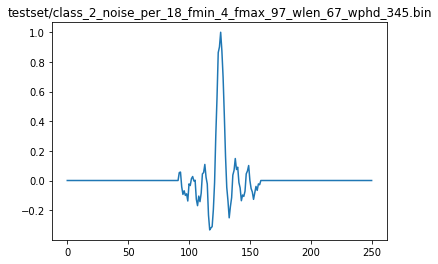

In [117]:
display_random_sample("testset")

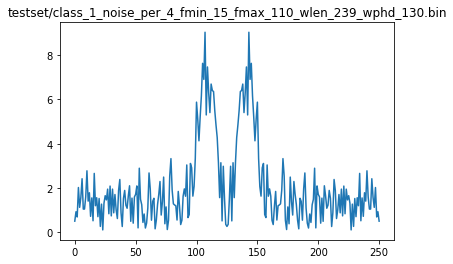

In [145]:
def display_random_sample_freq(dataset):
    # get random file
    filename = get_random_file(dataset) 
    sample = get_sample(filename)
    # plot random file
    sample_freq = np.fft.fft(sample)
    sample_freq = np.fft.fftshift(sample_freq)
    sample_mag = np.absolute(sample_freq)
    plt.title(filename)
    plt.plot(sample_mag) 
    plt.show()
display_random_sample_freq("testset")


# Setting Up New Dataset with Frequency-Based Samples

In [146]:
# Setting up new training dataset
# Get dataset and labels
train_dataset_size = 150*100
traindir = "trainset"

# initialize the dataset and labels
train_dataset = np.zeros((train_dataset_size, 251))
train_labels = np.zeros(train_dataset_size)

for i in range(train_dataset_size):
    # get file data
    filename = get_random_file(traindir)
    sample = get_sample(filename)
    snrdb = np.random.randint(2,20)
    sample = awgn(sample, snrdb)
    sample_freq = np.fft.fft(sample)
    sample_freq = np.fft.fftshift(sample_freq)
    sample_mag = np.absolute(sample_freq)
    train_dataset[i,:] = sample_mag
    
    # get first number from filenmae, this is the class id
    classid = int(re.search('[0-9]+', filename).group()) - 1
    train_labels[i] = classid

# Training New Model

In [147]:
# create network
model = create_network()
epochs = 15
print("Training for " + str(epochs) + " epochs using " + str(testdir) + " data")
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x=train_dataset, y=train_labels, epochs=epochs)

Training for 15 epochs using testset data
Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.3049 - accuracy: 0.9422
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1262 - accuracy: 0.9980
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0741 - accuracy: 0.9986
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0485 - accuracy: 0.9985
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0318 - accuracy: 0.9997
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0241 - accuracy: 0.9991
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0170 - accuracy: 0.9997
Epoch 8/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0127 - accuracy: 0.9997
Epoch 9/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0108 - accuracy: 0.9995
Epoch 10/15
469/469 [==============================] - 2s 

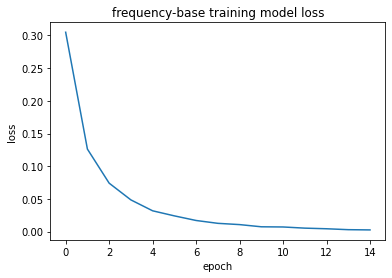

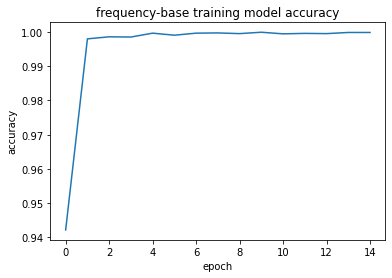

In [148]:
# Visualize learning progress 
plt.plot(history.history['loss'])
plt.title('frequency-base training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.plot(history.history['accuracy'])
plt.title('frequency-base training model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Test new model

In [149]:
# Testing new model
# Get dataset and labels
test_dataset_size = 20
testdir = "testset"

# initialize the dataset and labels
test_dataset = np.zeros((test_dataset_size, 251))
test_labels = np.zeros(test_dataset_size)

for i in range(test_dataset_size):
    # get file data
    filename = get_random_file(testdir)
    sample = get_sample(filename)    
    sample_freq = np.fft.fft(sample)
    sample_freq = np.fft.fftshift(sample_freq)
    sample_mag = np.absolute(sample_freq)
    test_dataset[i,:] = sample_mag
    
    # get first number from filenmae, this is the class id
    classid = int(re.search('[0-9]+', filename).group()) - 1
    test_labels[i] = classid

In [195]:
filename = get_random_file("testset")
print(filename)
test_loss, test_acc = model.evaluate(test_dataset, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

testset/class_2_noise_per_4_fmin_14_fmax_144_wlen_131_wphd_100.bin
1/1 [==============================] - 0s 22ms/step - loss: 0.0023 - accuracy: 1.0000

Test accuracy: 1.0
